In [1]:
import os
from fnmatch import fnmatch
from trainData_featExt_glcm import trainData_featExt_glcm
from trainData_featExt_gabor import trainData_featExt_gabor
import numpy as np
from PIL import Image
from filtering.filters import Median
from feature_extraction.lbp import Lbp
from sklearn.neighbors import NearestNeighbors
import sklearn
import time
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import pickle

In [2]:
#load training samples feature vector
train_samples_feats_matrix_glcm = np.load("train_samples_feats_matrix_GLCM.npy")

In [3]:
#load training samples feature vector
train_samples_feats_matrix_lbp = np.load("train_samples_feats_matrix_LBP.npy")

In [4]:
#load training samples feature vector
valid_samples_feats_matrix_glcm = np.load("valid_samples_feats_matrix_GLCM.npy")

In [5]:
#load training samples feature vector
valid_samples_feats_matrix_lbp = np.load("valid_samples_feats_matrix_LBP.npy")

In [6]:
#concatenating features 
train_samples_feats_matrix_glcm_lbp = np.concatenate((train_samples_feats_matrix_glcm,train_samples_feats_matrix_lbp), axis=1)
valid_samples_feats_matrix_glcm_lbp = np.concatenate((valid_samples_feats_matrix_glcm,valid_samples_feats_matrix_lbp), axis=1)

In [ ]:
#Train a KNN model using training data
t0 = time.time()
knn_model = NearestNeighbors(100, algorithm = 'kd_tree', metric ='manhattan')
knn_model.fit(train_samples_feats_matrix_glcm_gabor) 
print("traing time: ", time.time() - t0)

In [7]:
knn_model = pickle.load( open( "KNN_['GLCM', 'LBP']_50", "rb" ))

In [8]:
#find k nearest points for each sample
kth_dist, kth_ind = knn_model.kneighbors(train_samples_feats_matrix_glcm_lbp)
#1-D array contains distances of each data point to its kth nearest point 
kth_nearest_dist = kth_dist[:,-1]

In [9]:
#find k nearest points for each valid sample
kth_dist2, kth_ind2 = knn_model.kneighbors(valid_samples_feats_matrix_glcm_lbp)
#1-D array contains distances of each data point to its kth nearest point
kth_nearest_dist2 = kth_dist2[:,-1]
labels = np.repeat(0,10000)
#each validation data point whose distance to its kth nearest exceeds the 
#threshold, which is np.aman(kth_nearest_dist) is novel (0)
labels[kth_nearest_dist2 > np.mean(kth_nearest_dist)] = 1

In [10]:
#Ground truth
y1 = np.repeat(0, 6000) #normal
y2 = np.repeat(1, 4000) #abnormal
y = np.concatenate((y1,y2))

In [11]:
f1_binary = sklearn.metrics.f1_score(y, labels, average = 'binary')
f1_macro = sklearn.metrics.f1_score(y, labels, average = 'macro')
auc = sklearn.metrics.roc_auc_score(y, kth_nearest_dist2)
Math_Cof = sklearn.metrics.matthews_corrcoef(y, labels) 
kappa = sklearn.metrics.cohen_kappa_score(y, labels)
print("kappa ", kappa)
tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y, labels).ravel()
print ("f1_binary: ", f1_binary, "f1_macro: ", f1_macro, "MAth_cof: ", Math_Cof , " auc: ", auc)
print("confusion matrix", tn, fp, fn, tp)

('kappa ', 0.27664500709537687)
('f1_binary: ', 0.64056411208016339, 'f1_macro: ', 0.61024085022789343, 'MAth_cof: ', 0.32358009824053063, ' auc: ', 0.75812083333333335)
('confusion matrix', 2674, 3326, 548, 3452)


In [ ]:
#Get different thresholds value from ROC with corresponding F1_score and AUC
fpr,tpr,thresh = sklearn.metrics.roc_curve(y, kth_nearest_dist2)
for t, thres in enumerate (thresh) :
    labels = np.repeat(0,10000)
    labels[kth_nearest_dist2 > thres] = 1
    f1 = sklearn.metrics.f1_score(y, labels, average = 'macro')
    #auc = sklearn.metrics.roc_auc_score(y, kth_nearest_dist2)
    print ("f1: ", f1, "thres: ", thres)

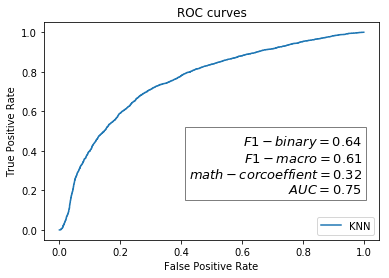

In [12]:
import matplotlib.pyplot as pl
import matplotlib
from skimage import io

fpr,tpr,thresh = sklearn.metrics.roc_curve(y,kth_nearest_dist2)
#print ('true positive rate: ',tpr )
#print ('true positive rate: ',1 - fpr )
f,ax = pl.subplots(1,1)
ax.plot(fpr,tpr,label="KNN")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curves")
ax.legend(loc="lower right")
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='square', facecolor='white', alpha=0.5)

textstr = '$F1-binary=%.2f$\n$F1-macro=%.2f$\n$math-corcoeffient=%.2f$\n$AUC=%.2f$'%(0.64, 0.61, 0.32, 0.75)
# place a text box in upper left in axes coords
ax.text(0.95, 0.2, textstr, transform=ax.transAxes, fontsize=13,
    horizontalalignment='right', verticalalignment='bottom', bbox=props)

io.show()

In [13]:
f.savefig('KNN_GLCM_LBP_50.png')